In [2]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline

def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.flipud(np.transpose(img0)))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.flipud(np.transpose(img1)))
    sub1.set_title(title1)

def plot_comparison3(img0, title0, img1, title1, img2, title2):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.flipud(np.transpose(img0)))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.flipud(np.transpose(img1)))
    sub1.set_title(title1)
    
    sub1 = fig2.add_subplot(2,2,3)
    sub1.imshow(np.flipud(np.transpose(img2)))
    sub1.set_title(title2)


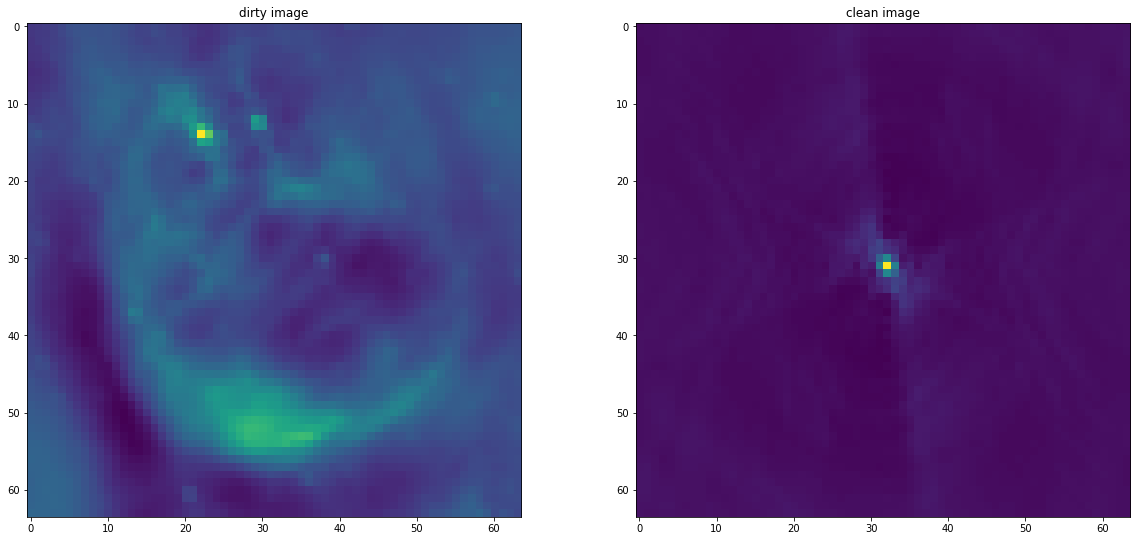

In [22]:
#folder = "./img-csv/test_64.64/"
#folder = "./img-csv/sun.flare00_64.64/"
#folder = "./img-csv/sun.center00_128.128/"
folder = "./img-csv/nova00_128.128/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',') [32:96,32:96]
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',') [32:96,32:96]
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',') [32:96,32:96]
model_map = np.genfromtxt(folder+'model.csv', delimiter=',') [32:96,32:96]

plot_comparison(dirty_map, 'dirty image', psf_map, 'clean image')

## Reconstruction with PSF in image space ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [4]:
model = Model("dirty-second try")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)        
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        row.append(model.addVar())
    pixelArr.append(row)

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print(elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  12.20703125 %
1.0
18.251648902893066


In [5]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_dirty01 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_dirty01[x,y]= pixelArr[x][y].x

Optimize a model with 4096 rows, 8192 columns and 1563486 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]
Presolve time: 0.47s
Presolved: 4096 rows, 8192 columns, 1563486 nonzeros
Presolved model has 4096 quadratic objective terms

       0    4.2339900e-03   0.000000e+00   2.587170e+01      1s
     874    8.0344504e-04   0.000000e+00   2.981282e-02      6s
    1359    8.0126571e-04   0.000000e+00   7.928486e-04     12s
    1467    8.0125504e-04   0.000000e+00   0.000000e+00     15s

Solved in 1467 iterations and 14.69 seconds
Optimal objective  8.012550398e-04


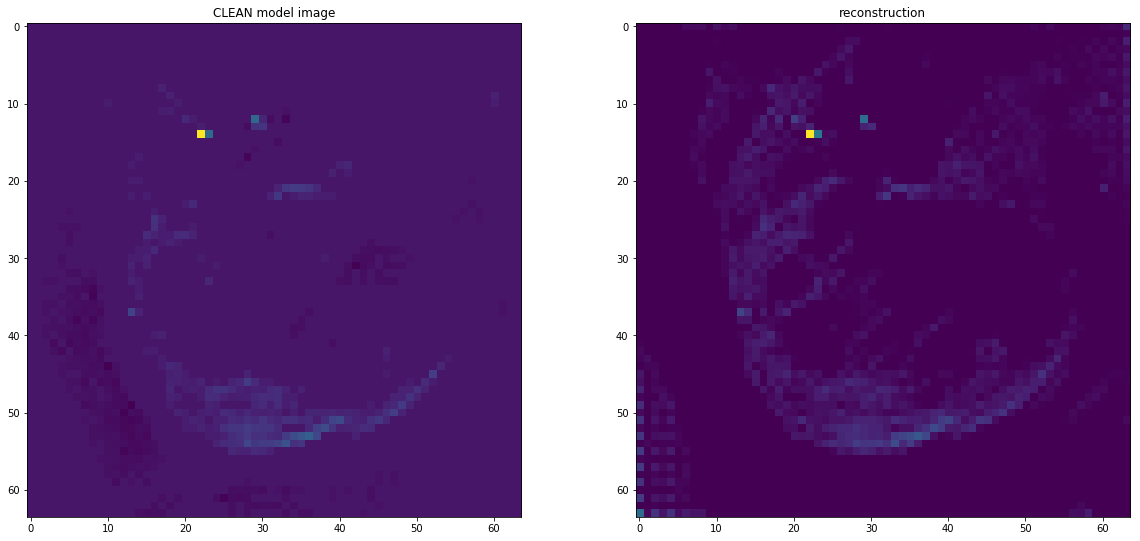

In [6]:
plot_comparison(model_map, 'CLEAN model image', results_dirty01, "reconstruction")

# Starlet Decomposition

In [7]:
def calcSpline():
    b3spline = np.asarray([1/16, 1/4, 3/8, 1/4, 1/16])
    row = np.asmatrix([b3spline])
    return(np.dot(np.transpose(row),row))

#repeat
def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0]*size[1], size[0]*size[1]))
    kernel = np.fliplr(np.flipud(kernel))
    
    disp = 2**J
    mid = kernel.shape[0]//2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset+y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    #print(xi, yi)
                    mx = xi // size[0] % 2
                    xi = xi % size[0]
                    if mx == 1:
                        xi = size[0] -1 - xi

                    my = yi // size[1] % 2
                    yi = yi % size[1]
                    if my == 1:
                        yi = size[1] -1 - yi
                    #print(mx, my, xi, yi)
                    temp[xi, yi] += kernel[i,j]
    return(output)

In [8]:
img = results_dirty01.copy()
b3spline = calcSpline()

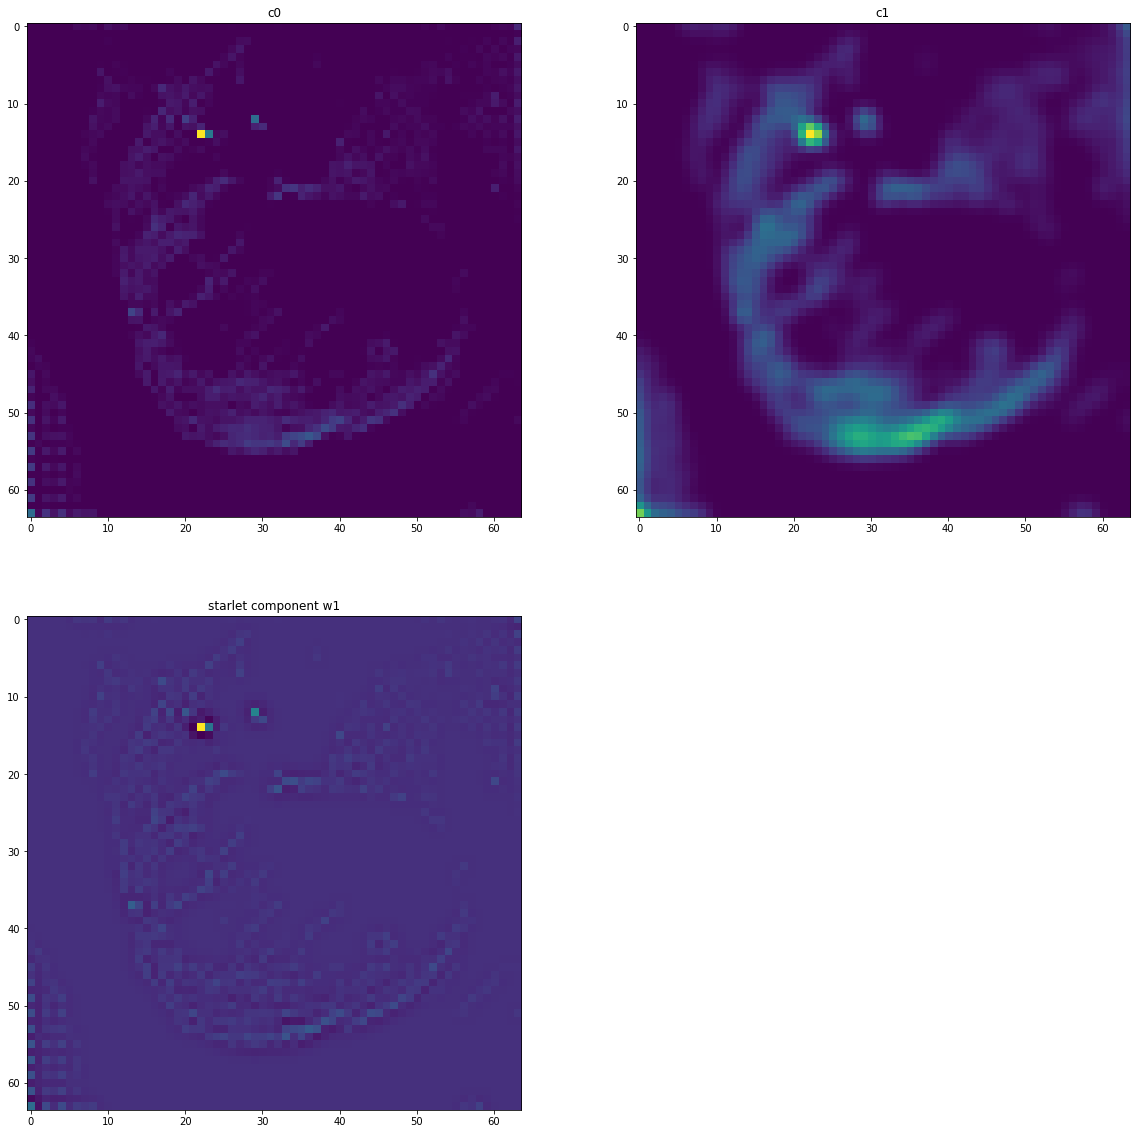

In [9]:
J = 0
M0 = calcConvMatrix(img.shape, b3spline, J)
c1 = np.reshape(np.dot(M0, img.flatten()), img.shape)
w1 = img - c1
plot_comparison3(img, "c0", c1, "c1", w1, "starlet component w1")

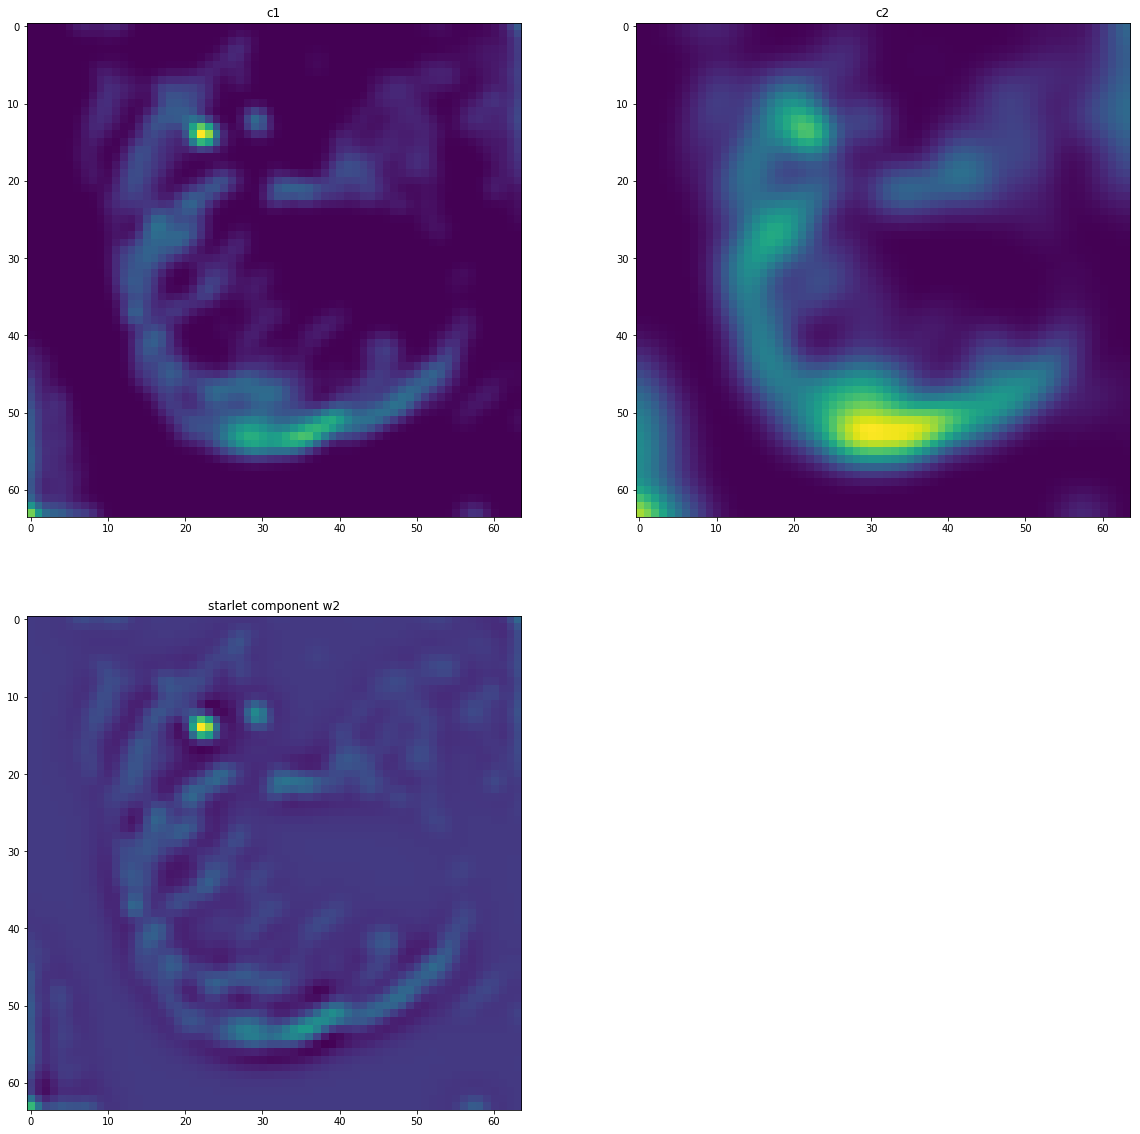

In [10]:
J = 1
M1 = calcConvMatrix(img.shape, b3spline, J)
c2 = np.reshape(np.dot(M1, c1.flatten()), img.shape)
w2 = c1 - c2
plot_comparison3(c1, "c1", c2, "c2", w2, "starlet component w2")

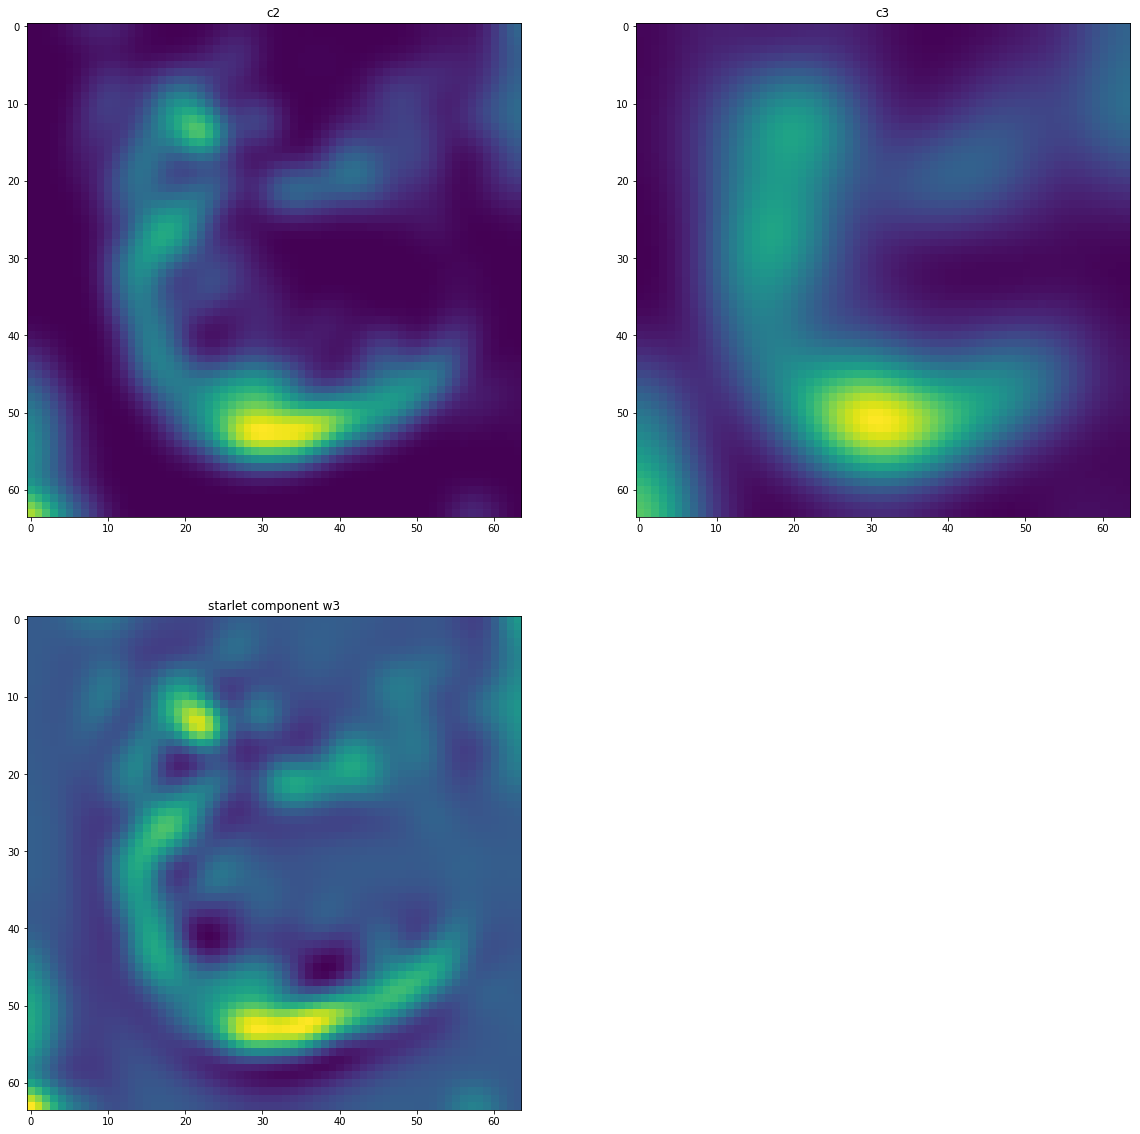

In [11]:
J = 2
MJ = calcConvMatrix(img.shape, b3spline, J)
c3 = np.reshape(np.dot(MJ, c2.flatten()), img.shape)
w3 = c2 - c3
plot_comparison3(c2, "c2", c3, "c3", w3, "starlet component w3")

# Clean with Starlet region detection

In [12]:
model = Model("starlet regularizer")
model.Params.method = 0 #GRB Primal Simplex 

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)
    
XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

start_time = time.time()
starlet_levels=1
#starlet_levels = int(math.log(dirty_map.shape[0], 2))
star_c = []
star_w = []
star_w_abs = []
b3spline = calcSpline()
M_previous = 0
for J in range(0, starlet_levels):
    print("modelling starlet level "+ str(J+1) +" of "+ str(starlet_levels))
    
    star_cJ = []
    star_wJ = []
    star_wJ_abs = []
    for x in range(0, dirty_map.size):
        star_cJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ_abs.append(model.addVar())
    star_c.append(star_cJ)
    star_w.append(star_wJ)
    star_w_abs.append(star_wJ_abs)
    
    star_cminus = 0
    if J == 0:
        star_cminus = pixel_flat
        MJ = calcConvMatrix(dirty_map.shape, b3spline, J)
    else:
        star_cminus = star_c[J-1]
        MJ = np.dot(M_previous,calcConvMatrix(dirty_map.shape, b3spline, J))
    for x in range(0, dirty_map.size):
        reg = LinExpr()
        reg.addTerms(MJ[x], pixel_flat)
        model.addConstr(star_cJ[x] == reg)
        model.addConstr(star_wJ[x] ==  star_cminus[x] - star_cJ[x])
        model.addGenConstrAbs(star_wJ_abs[x], star_wJ[x])
    M_previous = MJ

print("modeling cJ")
star_c_abs= []
for x in range(0, dirty_map.size):
    star_c_abs.append(model.addVar())
    model.addGenConstrAbs(star_c_abs[x], star_c[J-1][x])
    
elapsed_time = time.time() - start_time
print("done starlet modelling ", elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  12.20703125 %
1.0
done psf modelling  15.494994878768921
modelling starlet level 1 of 1
modeling cJ
done starlet modelling  17.961277961730957


Optimize a model with 12288 rows, 24576 columns and 1678466 nonzeros
Model has 4096 quadratic objective terms
Model has 8192 general constraints
Variable types: 24576 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]
Presolve removed 8192 rows and 16384 columns
Presolve time: 2.24s
Presolved: 4096 rows, 8192 columns, 1563486 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 8192 continuous, 0 integer (0 binary)

Root relaxation: objective 4.233990e-03, 0 iterations, 0.29 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0042340    0.00423  0.00%     -    2s

Explored 0 nodes (0 simplex iterations) in 2.68 seconds
Thread count was 2 (of 2 avai

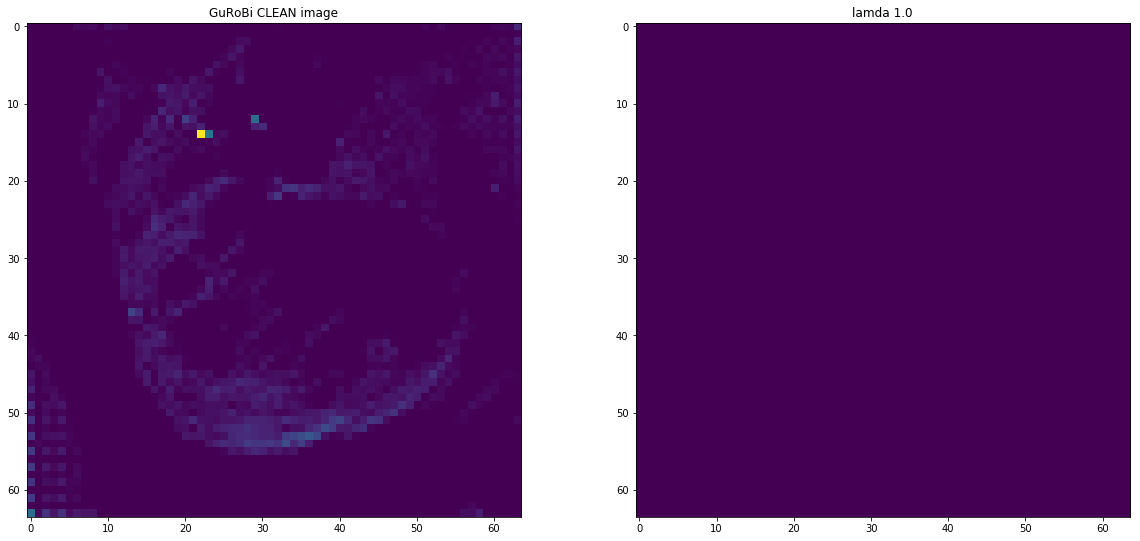

In [13]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 1                       
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet_100 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet_100[x,y]= pixelArr[x][y].x
        
plot_comparison(results_dirty01, 'GuRoBi CLEAN image', results_starlet_100, "lamda 1.0")

Optimize a model with 12288 rows, 24576 columns and 1678466 nonzeros
Model has 4096 quadratic objective terms
Model has 8192 general constraints
Variable types: 24576 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [5e-02, 5e-02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]

MIP start produced solution with objective 0.00415101 (2.35s)
Loaded MIP start with objective 0.00415101
Processed MIP start in 2.35 seconds

Presolve removed 8192 rows and 16384 columns
Presolve time: 2.03s
Presolved: 4096 rows, 8192 columns, 1563486 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 8192 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 23 iterations, 0.30 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0     

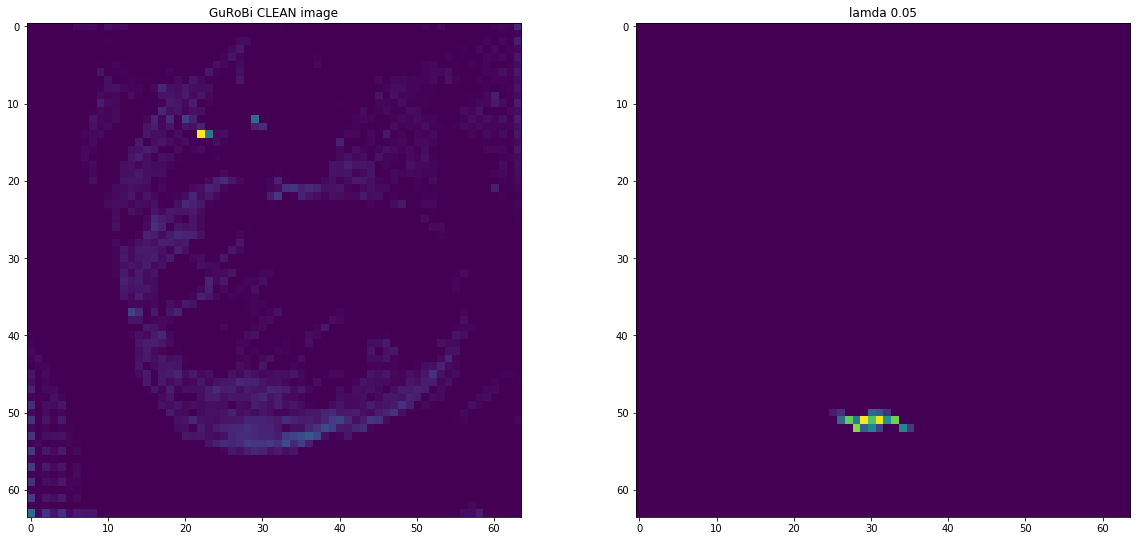

In [14]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.05
                                        
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet_005 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet_005[x,y]= pixelArr[x][y].x
        
plot_comparison(results_dirty01, 'GuRoBi CLEAN image', results_starlet_005, "lamda 0.05")

Optimize a model with 12288 rows, 24576 columns and 1678466 nonzeros
Model has 4096 quadratic objective terms
Model has 8192 general constraints
Variable types: 24576 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [2e-02, 2e-02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]

MIP start produced solution with objective 0.00340452 (2.45s)
Loaded MIP start with objective 0.00340452
Processed MIP start in 2.45 seconds

Presolve removed 8192 rows and 16384 columns
Presolve time: 2.21s
Presolved: 4096 rows, 8192 columns, 1563486 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 8192 continuous, 0 integer (0 binary)
       0    4.2339900e-03   0.000000e+00   5.812889e+00      5s

Root relaxation: cutoff, 142 iterations, 0.54 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

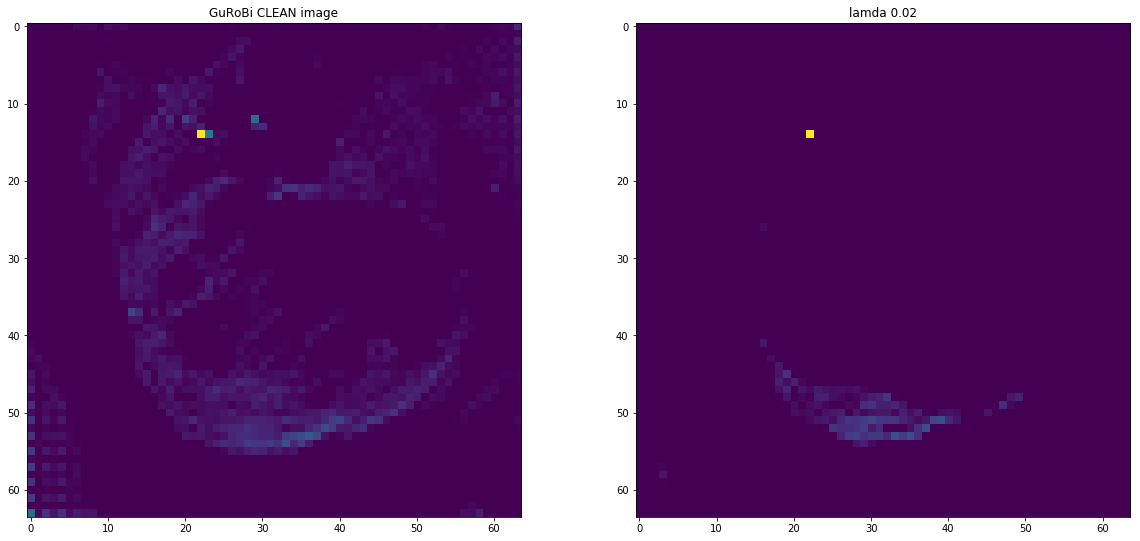

In [15]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.02
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet_002 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet_002[x,y]= pixelArr[x][y].x
        
plot_comparison(results_dirty01, 'GuRoBi CLEAN image', results_starlet_002, "lamda 0.02")

Optimize a model with 12288 rows, 24576 columns and 1678466 nonzeros
Model has 4096 quadratic objective terms
Model has 8192 general constraints
Variable types: 24576 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-03, 1e-03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]

MIP start produced solution with objective 0.00109374 (16.00s)
Loaded MIP start with objective 0.00109374
Processed MIP start in 15.99 seconds

Presolve removed 8192 rows and 16384 columns
Presolve time: 2.78s
Presolved: 4096 rows, 8192 columns, 1563486 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 8192 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00     19s
       0    4.2339900e-03   0.000000e+00   2.403132e+01     19s
     371    1.1151776e-

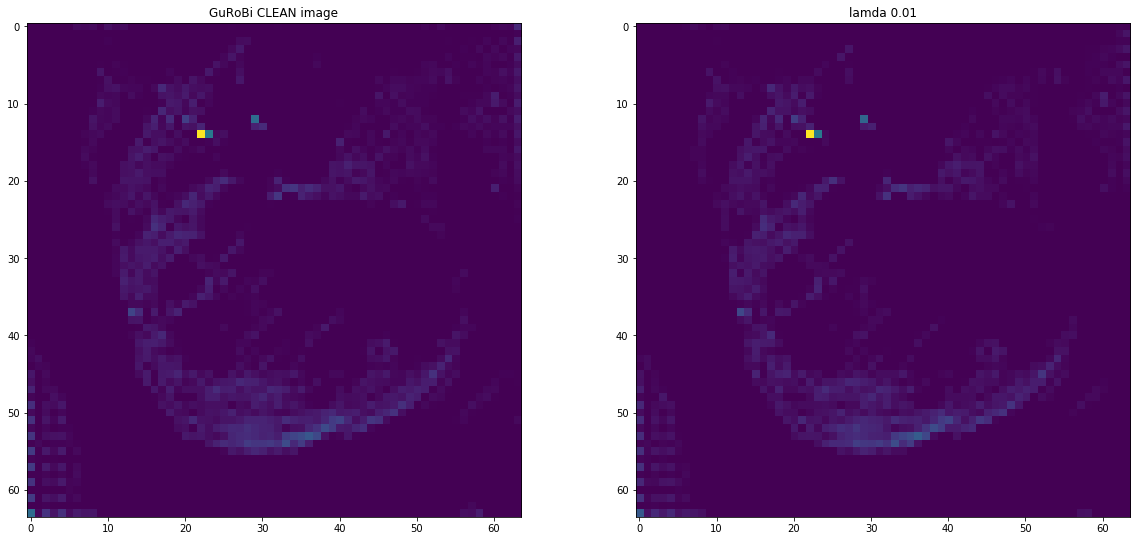

In [23]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.001                                      
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet_001 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet_001[x,y]= pixelArr[x][y].x
        
plot_comparison(results_dirty01, 'GuRoBi CLEAN image', results_starlet_001, "lamda 0.01")

# starlet reconstruction

In [24]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.001 / starlet_levels
for J in range(0, starlet_levels):
    star_wJ_abs = star_w_abs[J]
    for x in range(0, dirty_map.size):
        objective += lamb * star_wJ_abs[x]
                                        
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet[x,y]= pixelArr[x][y].x

Optimize a model with 12288 rows, 24576 columns and 1678466 nonzeros
Model has 4096 quadratic objective terms
Model has 8192 general constraints
Variable types: 24576 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-03, 1e-03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]

MIP start produced solution with objective 0.00116607 (114.40s)
Loaded MIP start with objective 0.00116607
Processed MIP start in 114.43 seconds

Presolve added 4096 rows and 0 columns
Presolve removed 0 rows and 8192 columns
Presolve time: 3.14s
Presolved: 16384 rows, 16384 columns, 1682562 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 16384 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00    118s
       0    4.2339900e-03   0.000000e+00   2.40

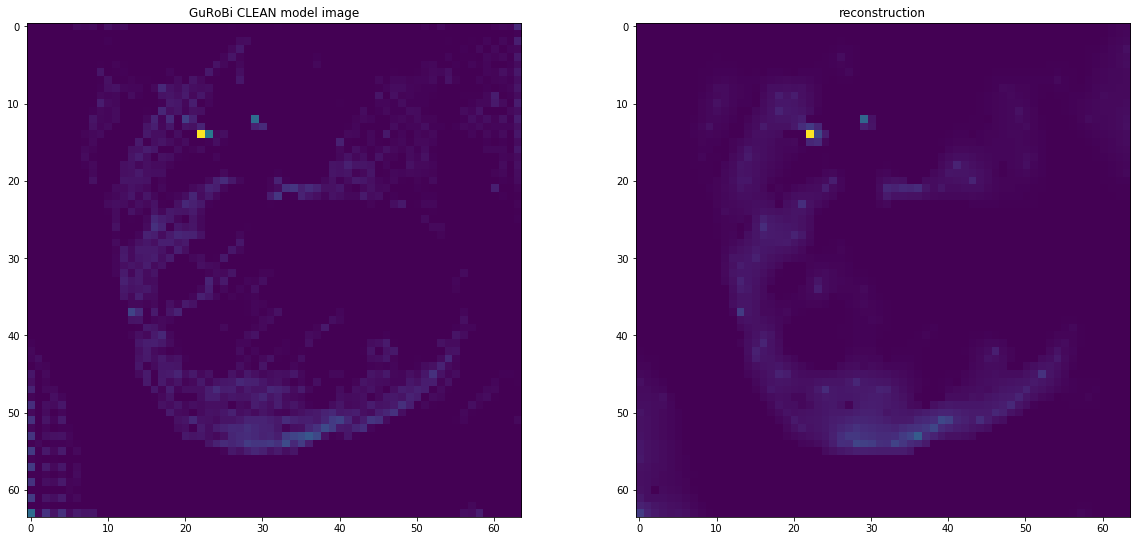

In [25]:
plot_comparison(results_dirty01, 'GuRoBi CLEAN model image', results_starlet, "reconstruction")

0.005935305758920866